In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from BS_pricer import BS_pricer
from Parameters import Option_param
from Processes import Diffusion_process

Den originale ligning (3.81) kan omskrives:

\begin{align*}
S\left(t\right)&=S\left(0\right)e^{\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)}\prod_{J=1}^{N\left(t\right)}Y_{J}\\\ln\left(S\left(t\right)\right)&=\ln\left(S\left(0\right)e^{\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)}\prod_{J=1}^{N\left(t\right)}Y_{J}\right)\\\ln\left(S\left(t\right)\right)&=\ln\left(S\left(0\right)\right)+\ln\left(e^{\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)}\right)+\ln\left(\prod_{J=1}^{N\left(t\right)}Y_{J}\right)\\\ln\left(S\left(t\right)\right)&=\ln\left(S\left(0\right)\right)+\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)+\sum_{J=1}^{N\left(t\right)}Y_{J}\\\exp\left(\ln\left(S\left(t\right)\right)\right)&=\exp\left(\ln\left(S\left(0\right)\right)+\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)+\sum_{J=1}^{N\left(t\right)}Y_{J}\right)\\S_{t}&=S\left(0\right)\exp\left(\underset{GBM}{\underbrace{\left(\mu-\frac{1}{2}\sigma^{2}\right)t+\sigma W\left(t\right)}}+\underset{\text{Jumps}}{\underbrace{\sum_{J=1}^{N\left(t\right)}Y_{J}}}\right)
\end{align*}

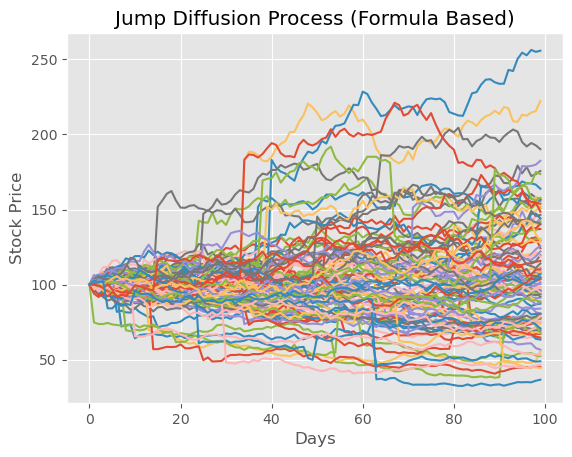

In [44]:
def merton_jump_paths_formula(S0, T, mu, sigma, lam, m, v, I, Npaths):
    dt = T / I  # Time increment
    t = np.linspace(0, T, I)  # Time grid
    
    # GBM component
    # Generate random Brownian motion paths
    W = np.random.randn(I, Npaths).cumsum(axis=0) * np.sqrt(dt)  # Cumulative sum of standard normals times sqrt(dt) gives W(t)
    # Calculate the geometric Brownian motion component for each path and time step
    GBM = np.zeros((I, Npaths))
    GBM[1:] = (mu - 0.5 * sigma**2) * t[1:, np.newaxis] + sigma * W[1:] #ensure it starts at 0
    
    # Jump component
    # Generate Poisson processes for jumps for each path and time step
    N = np.random.poisson(lam * dt, (I, Npaths)).cumsum(axis=0)  # Cumulative sum of Poisson gives N(t)
    # Generate jump sizes for each potential jump event; these are drawn from a log-normal distribution
    Y = np.exp(np.random.normal(m, v, (I, Npaths)))  # Jump sizes, which are log-normal
    # Initialize a matrix to hold the cumulative sum of jumps for each path
    jumps = np.zeros((I, Npaths))
    
    # Calculate the cumulative sum of jumps for each path
    for i in range(1, I):
        # For each time step, if there is a new jump (N[i] > N[i-1]), add its logarithm to the cumulative sum of jumps
        jumps[i] = jumps[i - 1] + np.where(N[i] > N[i - 1], np.log(Y[i]), 0)
    
    # Calculate the final price paths by combining the GBM and jump components and multiplying by the initial stock price
    return S0 * np.exp(GBM + jumps)


# Parameters
S0 = 100  # current stock price
T = 1  # time to maturity
mu = 0.02  # risk free rate
m = 0  # mean of jump size
v = 0.3  # standard deviation of jump
lam = 1  # intensity of jump i.e. number of jumps per annum
I = 100 # time steps
Npaths = 100  # number of paths to simulate
sigma = 0.2  # annual standard deviation, for Wiener process

# Simulate paths
j = merton_jump_paths_formula(S0, T, mu, sigma, lam, m, v, I, Npaths)
m = j.T

# Plotting
plt.plot(j)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process (Formula Based)')
plt.show()

# LSM approach

In [45]:
# show the paths in a table
print('Jump Diffusion Process (Formula Based)')
print('-------------------------------------')
print(m)

V = m[:, -1] # Terminal value

Jump Diffusion Process (Formula Based)
-------------------------------------
[[100.          96.35209939  98.28171819 ... 130.87745502 131.42754913
  124.22083869]
 [100.         100.54234568 101.65959581 ...  69.48747233  69.53900106
   69.86199453]
 [100.         105.00334961 102.77058092 ...  91.68839396  90.86807052
   91.27887303]
 ...
 [100.          98.92168679  95.3302209  ...  75.67177556  76.06987817
   79.14342821]
 [100.          99.84529176  99.40539661 ... 106.65039884 110.09608402
  110.04377365]
 [100.         102.94840426 101.48590332 ... 100.44316336 102.92946206
  104.84056928]]


In [46]:
K=110
#initialize payoff matrix of put option
payoff_matrix = np.maximum(K - m, 0)
print(payoff_matrix)

[[10.         13.64790061 11.71828181 ...  0.          0.
   0.        ]
 [10.          9.45765432  8.34040419 ... 40.51252767 40.46099894
  40.13800547]
 [10.          4.99665039  7.22941908 ... 18.31160604 19.13192948
  18.72112697]
 ...
 [10.         11.07831321 14.6697791  ... 34.32822444 33.93012183
  30.85657179]
 [10.         10.15470824 10.59460339 ...  3.34960116  0.
   0.        ]
 [10.          7.05159574  8.51409668 ...  9.55683664  7.07053794
   5.15943072]]


In [47]:
df = np.exp(-mu*T)  # discount factor
# Let us compute the value of american put with backward induction
for i in range (I-1, 0, -1): #count down backwards with -1 time steps from T to 0
    rg = np.polyfit(m[:, i], V*df, 3) #fits a polynomial of degree 3 to the data

    C = np.polyval(rg, m[:, i]) # evaluates the polynomial at m[:, i]

    V = np.where(payoff_matrix[:, i] > C, payoff_matrix[:, i], V*df)

V0 = df*np.mean(V)

print('The value of the American put option is: ', round(V0, 2))


The value of the American put option is:  17.73


A potential issue here is that when you're using regression to estimate the continuation values, you're using the entire dataset. In reality, you should only be regressing on "in-the-money" paths. So, you might want to add a filtering step to only consider paths where exercising the option is a possibility (i.e., paths where the intrinsic value is positive).

m[:, i] represents the stock prices at time step i for all simulated paths.
V*df represents the discounted expected future payoffs of the option from the next time step.

Text(0.5, 1.0, 'Jump Diffusion Process')

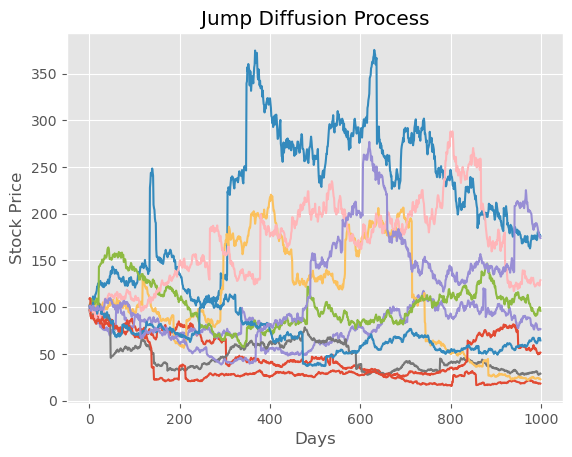

In [4]:
def merton_jump_paths(S0, T, mu, sigma,  lam, m, v, I, Npaths):
    size=(I,Npaths)
    dt = T/I 

    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size), np.random.normal(m,v, size=size)).cumsum(axis=0)

    geo = np.cumsum(((mu -  sigma**2/2 -lam*(m  + v**2*0.5))*dt + sigma*np.sqrt(dt) * np.random.normal(size=size)), axis=0)
    
    return np.exp(geo+poi_rv)*S0

S0 = 100 # current stock price
T = 10 # time to maturity
mu = 0.02 # risk free rate
m = 0 # meean of jump size
v = 0.3 # standard deviation of jump
lam =1 # intensity of jump i.e. number of jumps per annum
I = 1000 # time steps
Npaths = 10 # number of paths to simulate
sigma = 0.2 # annaul standard deviation , for weiner process

j = merton_jump_paths(S0, T, mu, sigma, lam, m, v, I, Npaths)

plt.plot(j)
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Jump Diffusion Process')

[[100.         100.10984506 100.94884127 ... 127.67311218 130.96982812
  130.10437604]
 [100.         103.51756536 106.33292388 ... 118.69239519 122.092187
  124.3592926 ]
 [100.         101.39513057 101.92360386 ... 116.64582742 117.10006005
  114.19249386]
 ...
 [100.          99.74904188  97.13832387 ... 139.71502867 142.08093102
  143.48878124]
 [100.          99.05665054  97.97665945 ... 110.05675602 115.46954195
  113.31018173]
 [100.          97.68755363  97.48514403 ... 104.21319662 107.06365489
  109.93189179]]


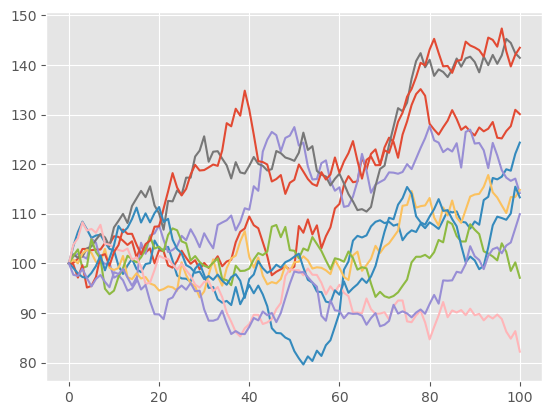

In [5]:
import numpy as np

def sample_paths_merton(S0, T, mu, sigma, lam, Y_dist, I, Npaths):
    """
    Simulate sample paths using the modified Merton Jump Diffusion model.

    Parameters:
    - S0: Initial asset price
    - T: Total time
    - mu: Expected return (drift)
    - sigma: Volatility of the continuous component
    - lam: Expected number of jumps in one time unit
    - Y_dist: A function that generates a random number from the Y distribution
    - I: Number of time intervals (steps)
    - Npaths: Number of paths to simulate

    Returns:
    - A 2D array of asset prices with shape (Npaths, I+1)
    """
    
    dt = T / I  # Time step size
    paths = np.zeros((Npaths, I+1))
    
    for path in range(Npaths):
        paths[path, 0] = S0
        X = np.log(S0)
        
        for i in range(1, I+1):
            Z = np.random.normal(0, 1)
            N = np.random.poisson(lam * dt)
            M = np.sum(np.log(Y_dist(size=N)))

            X += (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z + M
            paths[path, i] = np.exp(X)
    
    return paths

# Test the function using a uniform distribution for Y
Y_distribution = lambda size: np.random.uniform(0.9, 1.1, size)
paths = sample_paths_merton(S0=100, T=1, mu=0.05, sigma=0.2, lam=0.8, Y_dist=Y_distribution, I=100, Npaths=10)
print(paths)

plt.plot(paths.T)


[[100.         101.40899844 103.58047196 ...  70.85335906  70.72427913
   70.3193637 ]
 [100.          99.37373539  98.6507679  ...   0.           0.
    0.        ]
 [100.          95.2860207   91.35821358 ...   0.           0.
    0.        ]
 ...
 [100.         102.53912343  99.55202863 ...   0.           0.
    0.        ]
 [100.         101.06858255 100.83048591 ...   0.           0.
    0.        ]
 [100.          98.35858328  98.48143954 ... 117.09305587 120.04725825
  122.44225689]]


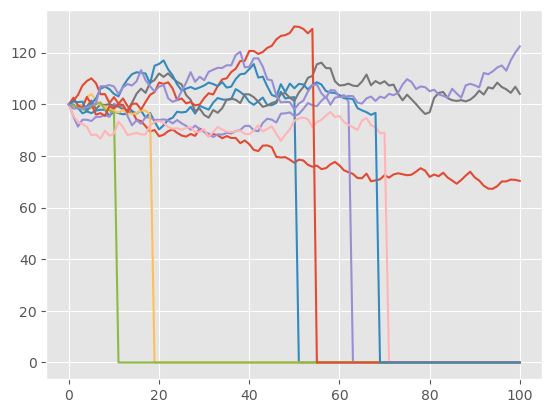

In [6]:
import numpy as np

def sample_paths_merton_drop(S0, T, mu, sigma, lam, I, Npaths):
    """
    Simulate sample paths using Merton Jump Diffusion model.

    Parameters:
    - S0: Initial asset price
    - T: Total time
    - mu: Expected return (drift)
    - sigma: Volatility of the continuous component
    - lam: Jump intensity
    - I: Number of time intervals (steps)
    - Npaths: Number of paths to simulate

    Returns:
    - A 2D array of asset prices with shape (Npaths, I+1)
    """
    
    dt = T / I  # Time step size
    paths = np.zeros((Npaths, I+1))
    
    for path in range(Npaths):
        paths[path, 0] = S0
        X = np.log(S0)
        
        for i in range(1, I+1):
            Z = np.random.normal(0, 1)
            N = np.random.poisson(lam * dt)

            if N == 0 and paths[path, i-1] > 0:
                X += (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
                paths[path, i] = np.exp(X)
            else:
                paths[path, i] = 0
    
    return paths

# Test the function
paths_1 = sample_paths_merton_drop(S0=100, T=1, mu=0.05, sigma=0.2, lam=0.8, I=100, Npaths=10)
print(paths_1)

plt.plot(paths_1.T)